# Importing the Data

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)

plt.rcParams['font.size'] = 12

In [5]:
file_path = './fraud.csv'
df = pd.read_csv(file_path)

In [6]:
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,0,7,437.63,3,Amex,65,883.17,Biometric,0.85,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,0,13,478.76,4,Mastercard,186,2203.36,Password,0.10,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,0,14,50.01,4,Visa,226,1909.29,Biometric,0.84,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,0,8,182.48,4,Visa,76,1311.86,OTP,0.79,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,1,14,328.69,4,Mastercard,140,966.98,Password,0.38,1,1


In [7]:
df.shape

(50000, 21)

# Exploring the Data

## Defining useful functions

In [31]:
def data_overview(df):
    """Provides a high-level summary of the DataFrame."""
    print("Shape of the DataFrame:", df.shape)
    df.info()

In [24]:
def explore_numerical_features(df, numerical_cols):
    """Visualizes the distribution of numerical features and displays descriptive statistics."""
    df[numerical_cols].hist(bins=20, figsize=(15, 10))
    plt.suptitle('Numerical Features', y=1.02)
    plt.show()
    display(df[numerical_cols].describe())

In [35]:
def explore_numerical_outliers(df, numerical_cols):
    plt.figure(figsize=(18, 12))
    for i, col in enumerate(numerical_cols):
        plt.subplot(3, 4, i + 1)
        sns.boxplot(y=df[col])
        plt.title(f'Box Plot of {col}')
    plt.tight_layout()
    plt.suptitle('Box Plots of Numerical Features', y=1.02)
    plt.show()

In [21]:
def explore_categorical_features(df, categorical_cols):
    """Visualizes the distribution of categorical features using bar plots in a grid."""
    num_cols = len(categorical_cols)
    if num_cols <= 0:
        return print("No categorical columns to explore.")
    
    rows = (num_cols + 2) // 3
    cols = min(num_cols, 3)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        if df[col].nunique() > 50:
            top_categories = df[col].value_counts().nlargest(10).index
            sns.countplot(data=df[df[col].isin(top_categories)], y=col, order=top_categories, ax=axes[i])
            axes[i].set_title(f'Top 10 of {col}')
        else:
            sns.countplot(data=df, y=col, order=df[col].value_counts().index, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
        axes[i].tick_params(axis='y', rotation=0)

    for j in range(num_cols, rows * cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle('Categorical Features', y=1.02)
    plt.show()

In [11]:
def split_features_target(df, target_column):
    """Splits the DataFrame into features (X) and the target variable (y)."""
    X = df.drop(columns=[target_column])
    y = df[target_column]
    print("\nFeatures (X) shape:", X.shape)
    print("Target (y) shape:", y.shape)
    return X, y

## Data Exploration

In [38]:
target_column = 'Fraud_Label'

# identifing numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

# removing the target column from the feature lists if it's present
if target_column in numerical_cols:
    numerical_cols.remove(target_column)
elif target_column in categorical_cols:
    categorical_cols.remove(target_column)

In [32]:
data_overview(df)

Shape of the DataFrame: (50000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7

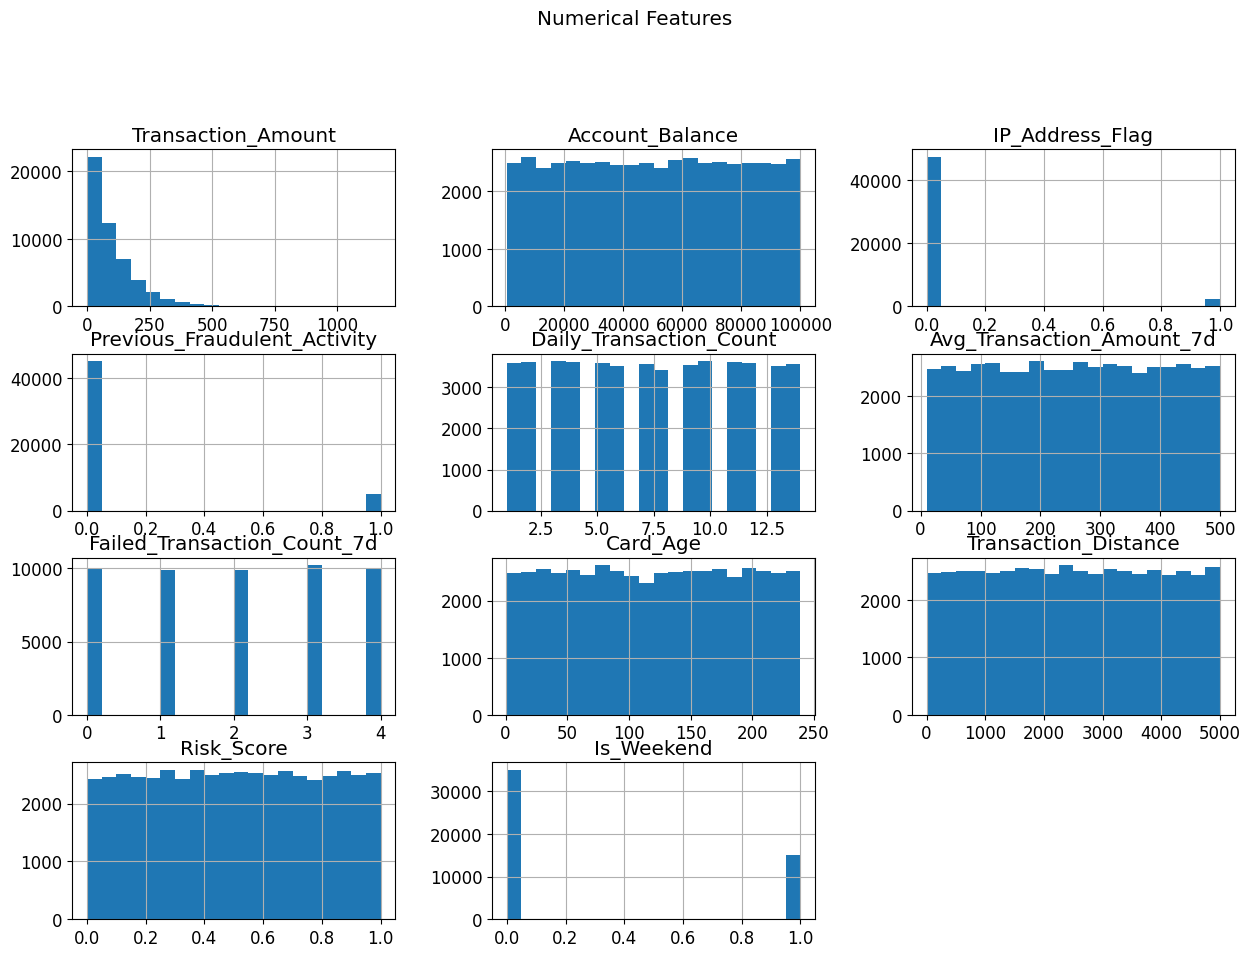

,Transaction_Amount,Account_Balance,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Age,Transaction_Distance,Risk_Score,Is_Weekend
count,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00
mean,99.41,50294.07,0.05,0.10,7.49,255.27,2.00,120.00,2499.16,0.50,0.30
std,98.69,28760.46,0.22,0.30,4.04,141.38,1.41,68.99,1442.01,0.29,0.46
min,0.00,500.48,0.00,0.00,1.00,10.00,0.00,1.00,0.25,0.00,0.00
25%,28.68,25355.99,0.00,0.00,4.00,132.09,1.00,60.00,1256.50,0.25,0.00
50%,69.66,50384.43,0.00,0.00,7.00,256.08,2.00,120.00,2490.78,0.50,0.00
75%,138.85,75115.14,0.00,0.00,11.00,378.03,3.00,180.00,3746.39,0.75,1.00
max,1174.14,99998.31,1.00,1.00,14.00,500.00,4.00,239.00,4999.93,1.00,1.00


In [39]:
explore_numerical_features(df[numerical_cols], numerical_cols)

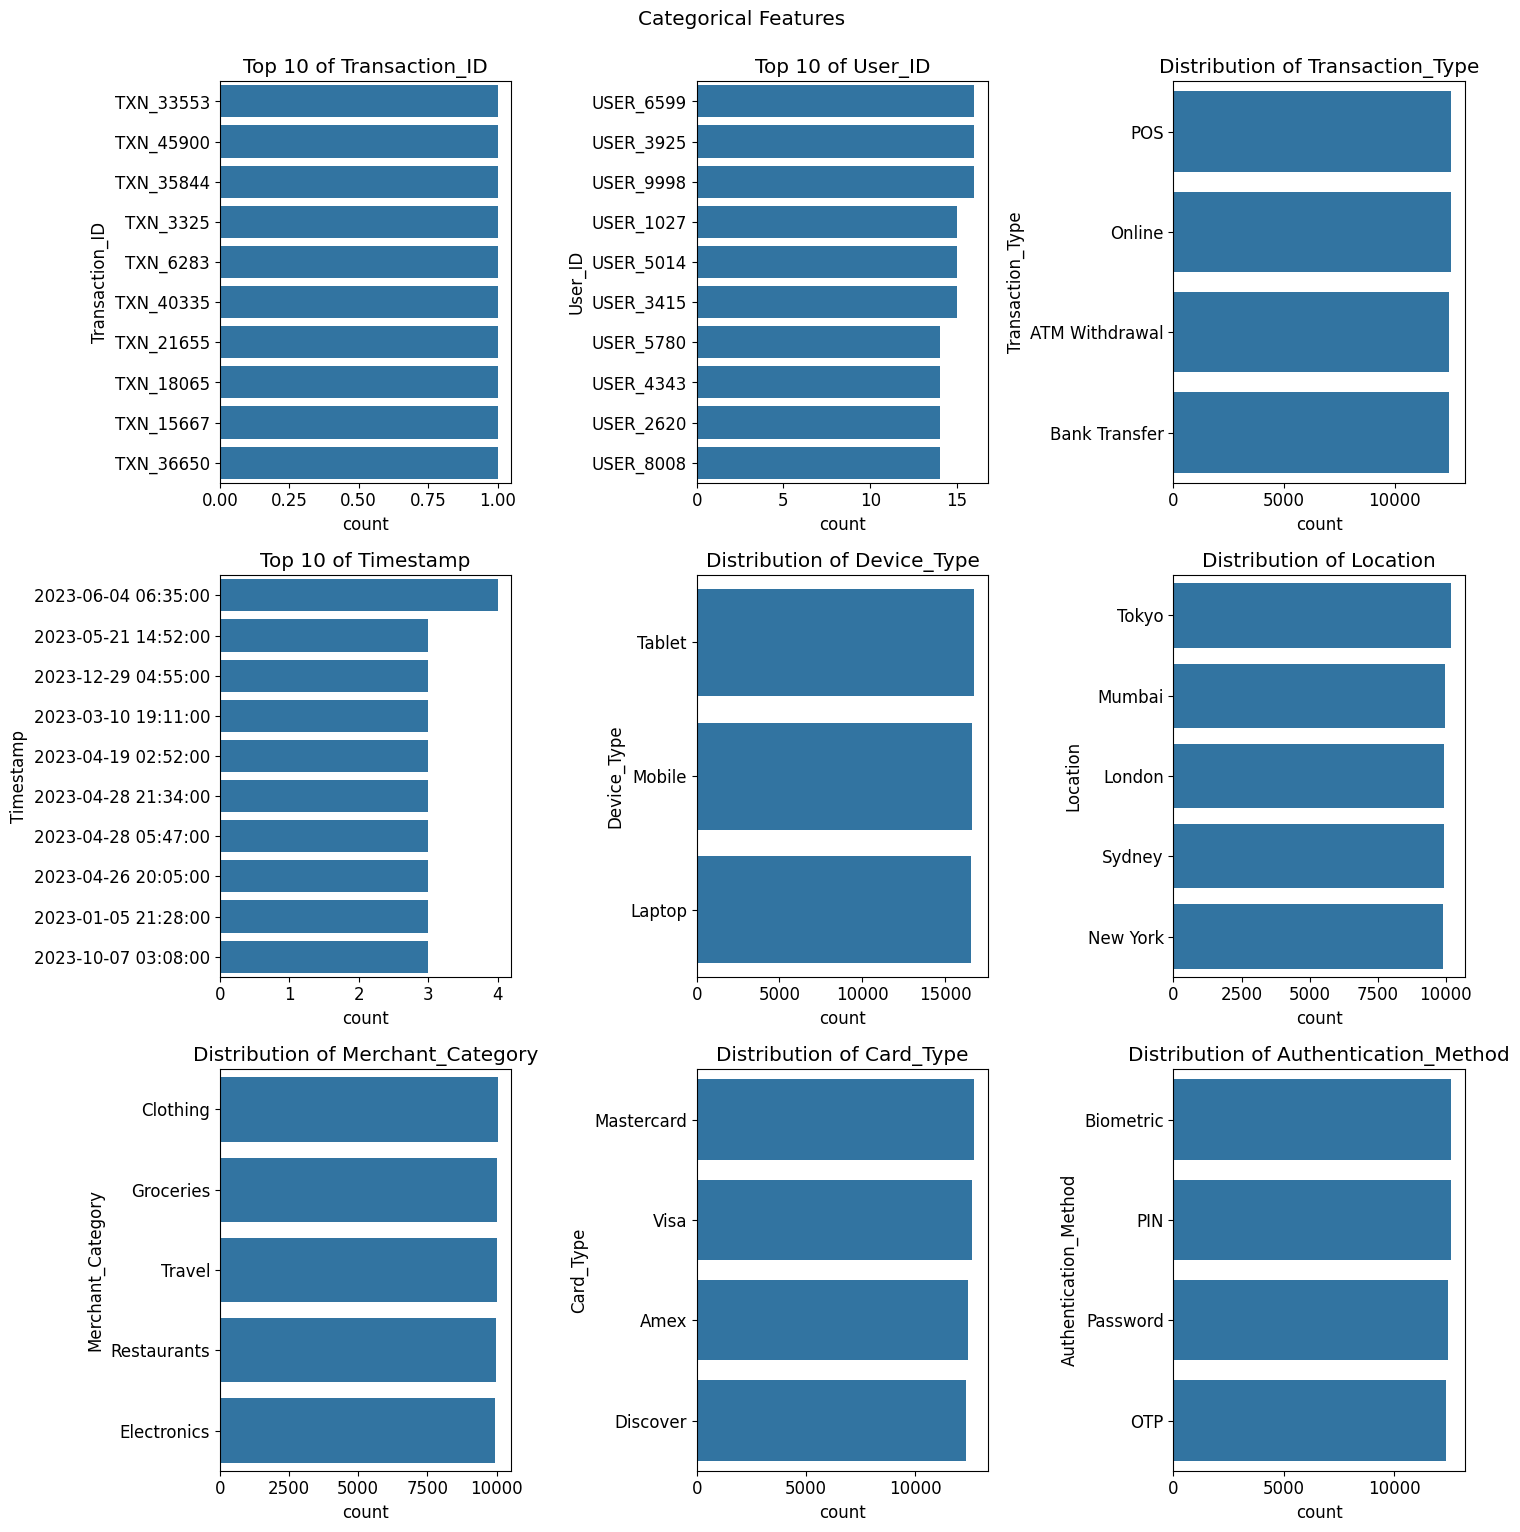

In [40]:
explore_categorical_features(df[categorical_cols], categorical_cols)

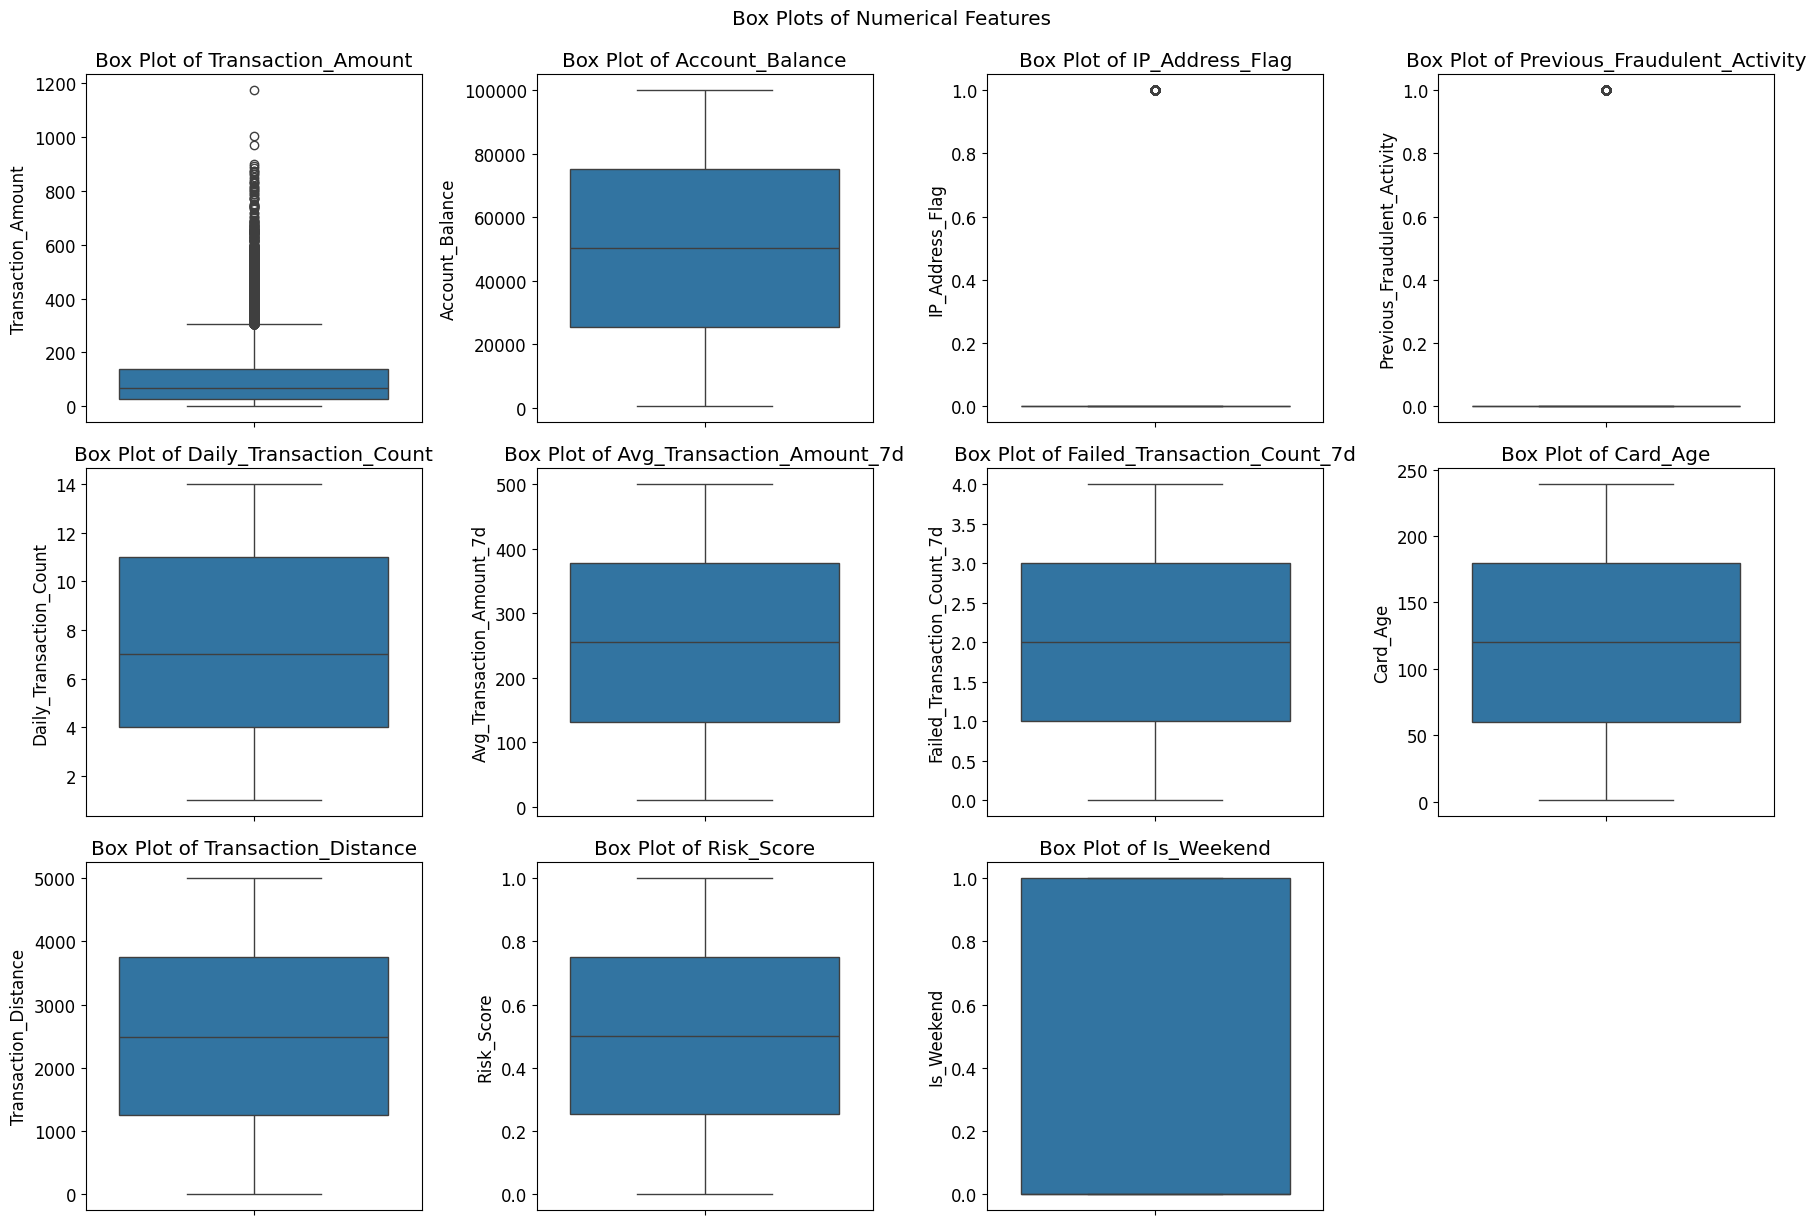

In [41]:
explore_numerical_outliers(df[numerical_cols], numerical_cols)

Fraud_Label
0    33933
1    16067
Name: count, dtype: int64


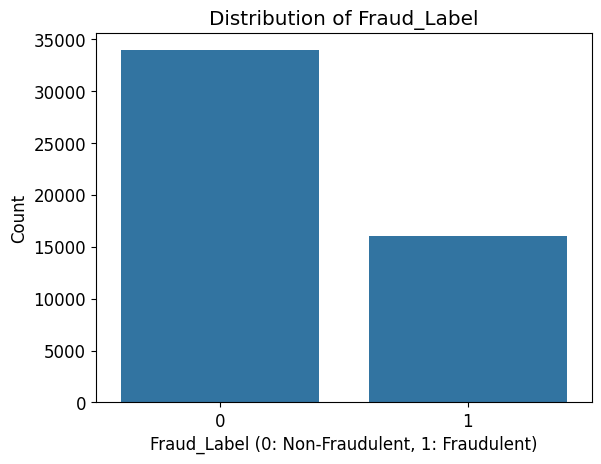

In [ ]:
print(df['Fraud_Label'].value_counts())

sns.countplot(data=df, x='Fraud_Label')
plt.title('Distribution of Fraud_Label')
plt.xlabel('Fraud_Label (0: Non-Fraudulent, 1: Fraudulent)')
plt.ylabel('Count')
plt.show()

**Looking for missing values**

In [64]:
for col in df.columns:
    print(f"\nColumn <{col}> has {df[col].nunique()} unique values")
    print(df[col].unique())


Column <Transaction_ID> has 50000 unique values
['TXN_33553' 'TXN_9427' 'TXN_199' ... 'TXN_38158' 'TXN_860' 'TXN_15795']

Column <User_ID> has 8963 unique values
['USER_1834' 'USER_7875' 'USER_2734' ... 'USER_5657' 'USER_8613'
 'USER_5580']

Column <Transaction_Amount> has 21763 unique values
[ 39.79   1.19  28.96 ... 122.76 315.08 109.62]

Column <Transaction_Type> has 4 unique values
['POS' 'Bank Transfer' 'Online' 'ATM Withdrawal']

Column <Timestamp> has 47724 unique values
['2023-08-14 19:30:00' '2023-06-07 04:01:00' '2023-06-20 15:25:00' ...
 '2023-01-30 19:32:00' '2023-03-09 19:47:00' '2023-08-19 23:57:00']

Column <Account_Balance> has 49867 unique values
[93213.17 75725.25  1588.96 ... 29916.41 67895.67  7668.82]

Column <Device_Type> has 3 unique values
['Laptop' 'Mobile' 'Tablet']

Column <Location> has 5 unique values
['Sydney' 'New York' 'Mumbai' 'Tokyo' 'London']

Column <Merchant_Category> has 5 unique values
['Travel' 'Clothing' 'Restaurants' 'Electronics' 'Groceries']

In [44]:
print(df.isnull().sum())

Transaction_ID                  0
User_ID                         0
Transaction_Amount              0
Transaction_Type                0
Timestamp                       0
Account_Balance                 0
Device_Type                     0
Location                        0
Merchant_Category               0
IP_Address_Flag                 0
Previous_Fraudulent_Activity    0
Daily_Transaction_Count         0
Avg_Transaction_Amount_7d       0
Failed_Transaction_Count_7d     0
Card_Type                       0
Card_Age                        0
Transaction_Distance            0
Authentication_Method           0
Risk_Score                      0
Is_Weekend                      0
Fraud_Label                     0
dtype: int64


In [53]:
object_cols = df.select_dtypes(include='object').columns
for col in object_cols:
    blank_count = df[df[col].str.strip() == ''].shape[0]
    if blank_count > 0:
        print(f"{blank_count} blank strings in column: <{col}>")
    else:
        print(f"NO blank strings in column: <{col}>")

NO blank strings in column: <Transaction_ID>
NO blank strings in column: <User_ID>
NO blank strings in column: <Transaction_Type>
NO blank strings in column: <Timestamp>
NO blank strings in column: <Device_Type>
NO blank strings in column: <Location>
NO blank strings in column: <Merchant_Category>
NO blank strings in column: <Card_Type>
NO blank strings in column: <Authentication_Method>


# Feature Engineering

## Splitting the data

In [75]:
from sklearn.model_selection import train_test_split

x = df.drop('Fraud_Label', axis=1)
y = df['Fraud_Label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

In [69]:
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print('y_train: ', y_train.value_counts(normalize=True))
print('y_test: ', y_test.value_counts(normalize=True))

Shape of x_train: (35000, 20)
Shape of x_test: (15000, 20)
Shape of y_train: (35000,)
Shape of y_test: (15000,)
y_train:  Fraud_Label
0   0.68
1   0.32
Name: proportion, dtype: float64
y_test:  Fraud_Label
0   0.68
1   0.32
Name: proportion, dtype: float64


## Standartization

In [76]:
# removing unnecessary columns

x_train = x_train.drop('Transaction_ID', axis=1)
x_test = x_test.drop('Transaction_ID', axis=1)

x_train['Timestamp'] = pd.to_datetime(x_train['Timestamp'])
x_test['Timestamp'] = pd.to_datetime(x_test['Timestamp'])

# extracting features from Timestamp
x_train['hour'] = x_train['Timestamp'].dt.hour
x_train['day_of_week'] = x_train['Timestamp'].dt.dayofweek
x_train['month'] = x_train['Timestamp'].dt.month

x_test['hour'] = x_test['Timestamp'].dt.hour
x_test['day_of_week'] = x_test['Timestamp'].dt.dayofweek
x_test['month'] = x_test['Timestamp'].dt.month

x_train = x_train.drop('Timestamp', axis=1)
x_test = x_test.drop('Timestamp', axis=1)

x_train = x_train.drop('User_ID', axis=1)
x_test = x_test.drop('User_ID', axis=1)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (35000, 20)
Shape of x_test: (15000, 20)


In [77]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

categorical_features = x_train.select_dtypes(include=['object', 'bool']).columns
numerical_features = x_train.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

print("Shape of processed x_train:", x_train_processed.shape)
print("Shape of processed x_test:", x_test_processed.shape)

Shape of processed x_train: (35000, 39)
Shape of processed x_test: (15000, 39)


In [78]:
for col in categorical_features:
    unique_count = x_train[col].nunique()
    print(f"Column <{col}> has {unique_count} unique values.")

Column <Transaction_Type> has 4 unique values.
Column <Device_Type> has 3 unique values.
Column <Location> has 5 unique values.
Column <Merchant_Category> has 5 unique values.
Column <Card_Type> has 4 unique values.
Column <Authentication_Method> has 4 unique values.


## Oversampling

Shape of processed x_train before SMOTE: (35000, 39)
Shape of y_train before SMOTE: (35000,)
Shape of processed x_train after SMOTE: (47506, 39)
Shape of y_train after SMOTE: (47506,)

Distribution of target variable in training set AFTER SMOTE:
Fraud_Label
0    23753
1    23753
Name: count, dtype: int64


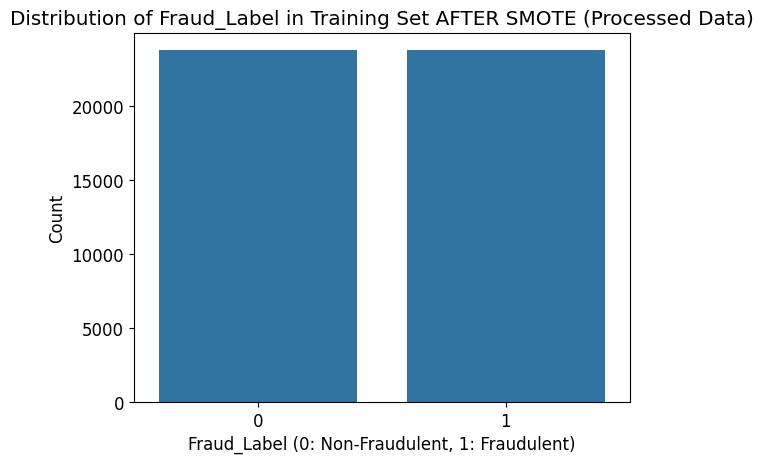

In [ ]:
smote = SMOTE(random_state=42)

x_train_smote, y_train_smote = smote.fit_resample(x_train_processed, y_train)

print("Shape of processed x_train before SMOTE:", x_train_processed.shape)
print("Shape of y_train before SMOTE:", y_train.shape)
print("Shape of processed x_train after SMOTE:", x_train_smote.shape)
print("Shape of y_train after SMOTE:", y_train_smote.shape)

print("\nDistribution of target variable in training set:")
print(pd.Series(y_train_smote).value_counts())

sns.countplot(x=pd.Series(y_train_smote))
plt.title('Distribution of Fraud_Label in Training Set')
plt.xlabel('Fraud_Label (0: Non-Fraudulent, 1: Fraudulent)')
plt.ylabel('Count')
plt.show()

# Model Selection

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

def train_evaluate_model(model, param_grid, x_train, y_train, cv=5, scoring='f1'):
    """
    Trains and evaluates a model using GridSearchCV.

    Args:
        model: model object (e.g., LogisticRegression())
        param_grid: dict of hyperparameters
        X_train: training features
        y_train: training target variable
        cv: number of cross-validation folds.
        scoring: scoring metric to use.

    Returns:
        The best trained model found by GridSearchCV.
    """
    print(f"Training and evaluating {model.__class__.__name__}...")

    if scoring == 'f1':
        scorer = make_scorer(f1_score)
    else:
        scorer = scoring

    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring=scorer,
                               cv=cv,
                               n_jobs=-1,
                               verbose=1)

    grid_search.fit(x_train, y_train)

    print()
    print(f"Best Hyperparameters for {model.__class__.__name__}:", grid_search.best_params_)
    print(f"Best {scoring} Score for {model.__class__.__name__}:", grid_search.best_score_)

    return grid_search.best_estimator_

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


models_to_train = [
    {
        'name': 'Logistic Regression',
        'model': LogisticRegression(random_state=42),
        'param_grid': {
            'penalty': ['l1', 'l2'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear']
        }
    },
    {
        'name': 'K-Nearest Neighbors',
        'model': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1, 2]
        }
    },
    {
        'name': 'Decision Tree',
        'model': DecisionTreeClassifier(random_state=42),
        'param_grid': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 3, 5]
        }
    },
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 3],
            'class_weight': ['balanced', 'balanced_subsample']
        }
    },
    {
        'name': 'Gradient Boosting',
        'model': GradientBoostingClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0]
        }
    }
]

## Training and Scoring

In [83]:
best_models = {}

for model_info in models_to_train:
    name = model_info['name']
    model = model_info['model']
    param_grid = model_info['param_grid']

    print(f"\n--- Training and Evaluating {name} ---")
    best_model = train_evaluate_model(model=model,
                                       param_grid=param_grid,
                                       X_train=x_train_smote,
                                       y_train=y_train_smote,
                                       scoring='f1')
    best_models[name] = best_model

print("\n--- Best Models Summary ---")
for name, model in best_models.items():
    print(f"Best model for {name}: {model}")


--- Training and Evaluating Logistic Regression ---
Training and evaluating LogisticRegression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters for LogisticRegression: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Best f1 Score for LogisticRegression: 0.8275727186435773

--- Training and Evaluating K-Nearest Neighbors ---
Training and evaluating KNeighborsClassifier...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Hyperparameters for KNeighborsClassifier: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Best f1 Score for KNeighborsClassifier: 0.9227838741669654

--- Training and Evaluating Decision Tree ---
Training and evaluating DecisionTreeClassifier...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best f1 Score for DecisionTreeClassifier: 0.9

## Evaluating results

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(test_f1_scores.keys()), y=list(test_f1_scores.values()))
plt.title('Test Set F1-Scores for Different Models')
plt.xlabel('Model')
plt.ylabel('F1-Score (Weighted Average)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


--- Evaluation of LogisticRegression on Test Set ---
              precision    recall  f1-score   support

           0       0.91      0.77      0.84     10180
           1       0.64      0.84      0.72      4820

    accuracy                           0.79     15000
   macro avg       0.77      0.81      0.78     15000
weighted avg       0.82      0.79      0.80     15000



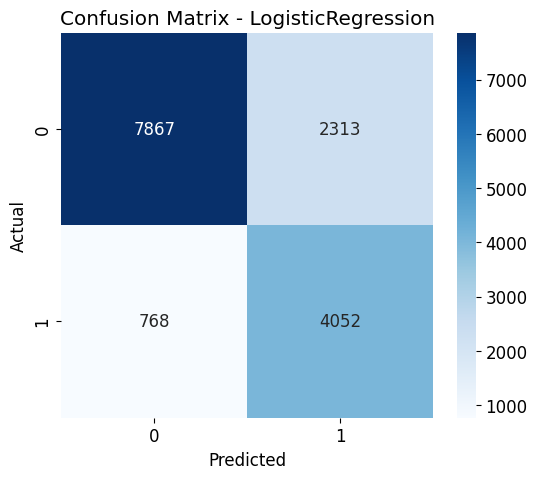


--- Evaluation of KNeighborsClassifier on Test Set ---
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     10180
           1       0.76      0.78      0.77      4820

    accuracy                           0.85     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.85      0.85      0.85     15000



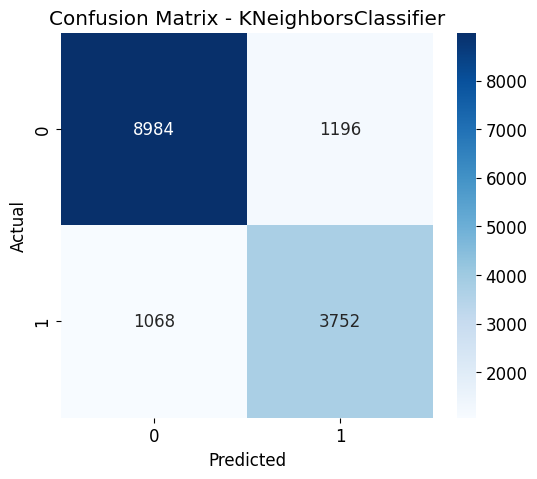


--- Evaluation of DecisionTreeClassifier on Test Set ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10180
           1       1.00      1.00      1.00      4820

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



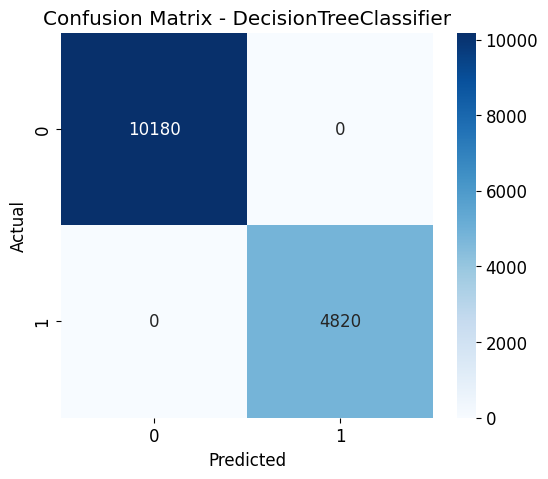


--- Evaluation of RandomForestClassifier on Test Set ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10180
           1       1.00      1.00      1.00      4820

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



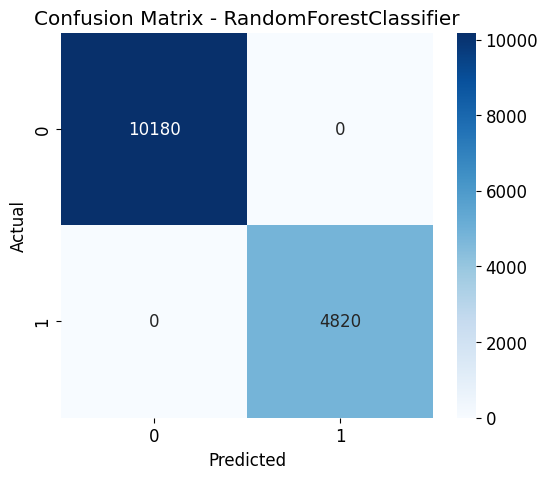


--- Evaluation of GradientBoostingClassifier on Test Set ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10180
           1       1.00      1.00      1.00      4820

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



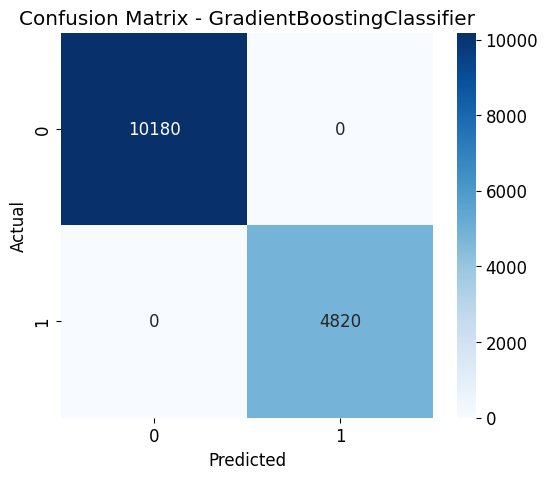

In [85]:
from sklearn.metrics import classification_report, confusion_matrix

test_f1_scores = {}

def evaluate_model_on_test(model, x_test, y_test):
    """Evaluates a trained model on the test set and prints metrics."""
    y_pred = model.predict(x_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1 = report['weighted avg']['f1-score']
    test_f1_scores[model.__class__.__name__] = f1
    
    print(f"\n--- Evaluation of {model.__class__.__name__} on Test Set ---")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return f1

for name, model in best_models.items():
    evaluate_model_on_test(model, x_test_processed, y_test)

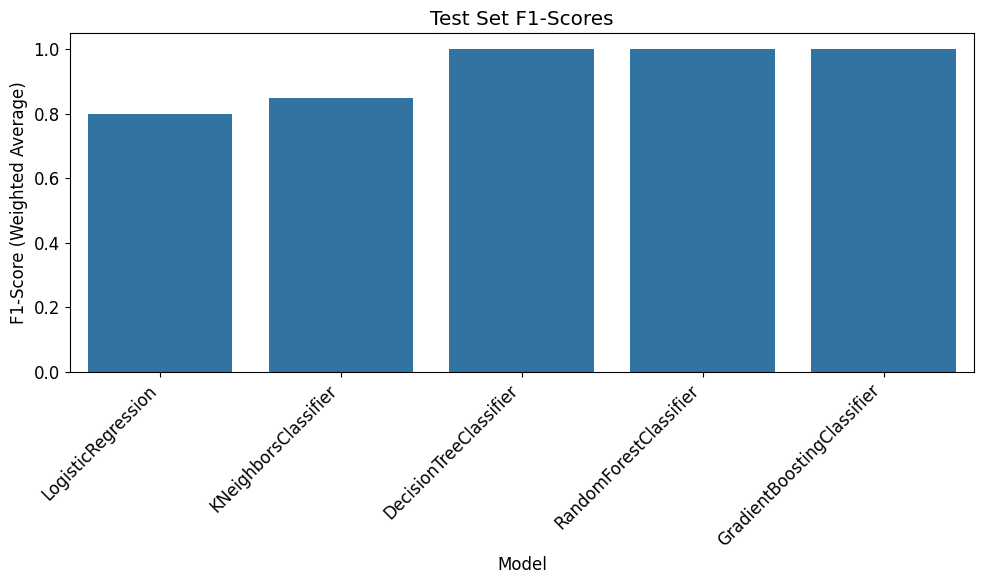

In [87]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(test_f1_scores.keys()), y=list(test_f1_scores.values()))
plt.title('Test Set F1-Scores')
plt.xlabel('Model')
plt.ylabel('F1-Score (Weighted Average)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()